This notebook will walk through the problem of a naive estimate in the context of program evaluation!

This type of work is usually done in stata (within academia), however, I have chosen to use python instead!

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from session1_helper import *
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["axes.labelsize"] = 20
plt.rcParams['legend.fontsize'] = 20

/Users/ibrahimgabr/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Below I am loading in an unbalanced dataset in order to highlight the selection problem that results in an biased naive estimate. Later on, I will load a balanced data set and we will explore waht implications that has in a naive estimate.

In [2]:
data = pd.read_stata("Dataset_Unbalanced.dta")
data.head()

income    D  collegegpa  collegetop50  salarybefore  parentsincome
0  1007425.250  0.0    3.650318           0.0  30708.693359  258256.796875
1  1496021.625  0.0    3.602348           0.0  28019.833984  400613.500000
2  1151806.875  0.0    3.734794           1.0  36278.148438  299807.718750
3  1480587.625  0.0    3.722654           0.0  33722.035156  396016.093750
4  1487158.125  0.0    3.701133           0.0  33228.523438  397917.343750

- income is the person’s annual salary

- D is a dummy of 1 if person went to Harris, 0 if rejected applicant 

- collegegpa is the person’s GPA from college

- collegetop50 is a dummy of 1 if person went to a college in the top-50 ranking, 0 if didn’t

- salarybefore is how much the person was making before applying to Harris 

- parentsincome is how much the person’s parents made per year when she applied to Harris

As such, the column D, represents whether a person had the treatment (i.e. is a harris student) or was denied treatment (rejected from Harris).

In [3]:
data.shape

(228, 6)

The treated_avg_mean is equivalent to $Y_{1, D=1}$ - imagine I had put a "bar" over the $Y$, because we are talking about the average. I omitted the bar as it is not rendering properly!

In [4]:
treated_avg_mean = data[data['D'] == 1.0]['income'].mean()
treated_avg_mean

1376930.375

untreated_avg_mean is equivalent to $Y_{0, D=0}$ - again, dont forget the bar over the $Y$

In [5]:
untreated_avg_mean = data[data['D'] == 0.0]['income'].mean()
untreated_avg_mean

1288897.375

In [6]:
naive_estimate = treated_avg_mean - untreated_avg_mean
naive_estimate

88033.0

Let's now explore the data in a bunch of different ways to see if there is any hintiong of a selection problem.

By selection problem, I mean that there are signfificant differences between the treatment and non-treatment groups. That is to say, there are statistically signfificant differences in the two groups regardless of treatment, thus, we will show that the naive estimate is a **biased** estimate for estimating the impact of obtaining treatment.

By biased, I mean the niave estimate over or under-emphasizes the effect of treatment.

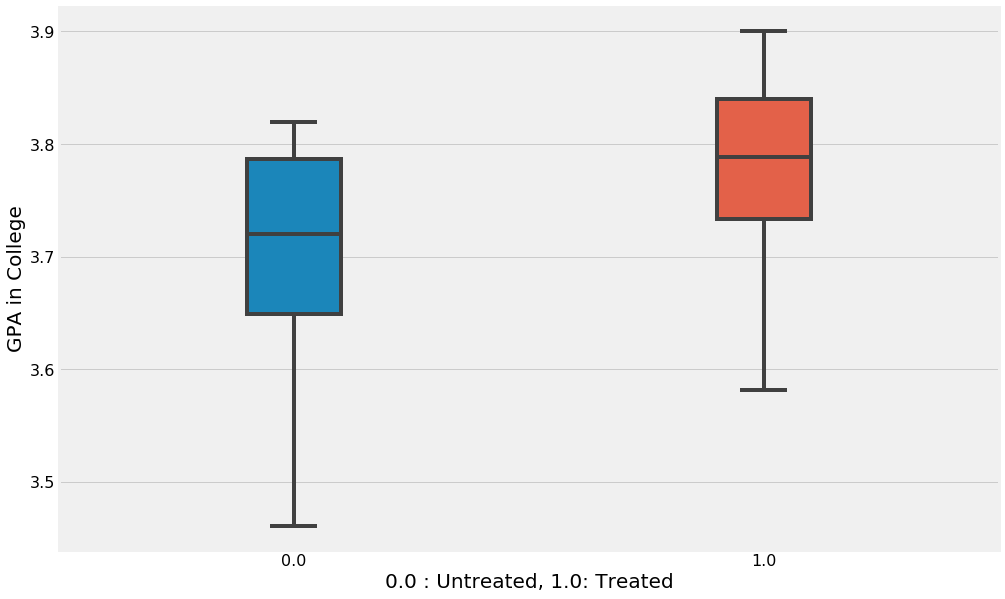

In [7]:
sns.boxplot(x=data['D'], y=data['collegegpa'], width=0.2);
plt.ylabel("GPA in College")
plt.xlabel("0.0 : Untreated, 1.0: Treated")

In [8]:
treated_group = data[data['D'] == 1.0]
treated_group.head()

income    D  collegegpa  collegetop50  salarybefore  parentsincome
114  1311299.000  1.0    3.853177           1.0  42366.343750   338621.40625
115  1380996.875  1.0    3.672254           0.0  43086.902344   358870.84375
116  1370002.875  1.0    3.897088           0.0  37651.343750   355363.40625
117  1178426.375  1.0    3.723969           1.0  40404.875000   298953.12500
118  1396510.875  1.0    3.775611           0.0  42059.921875   363388.78125

In [9]:
untreated_group = data[data['D'] == 0.0]
untreated_group.head()

income    D  collegegpa  collegetop50  salarybefore  parentsincome
0  1007425.250  0.0    3.650318           0.0  30708.693359  258256.796875
1  1496021.625  0.0    3.602348           0.0  28019.833984  400613.500000
2  1151806.875  0.0    3.734794           1.0  36278.148438  299807.718750
3  1480587.625  0.0    3.722654           0.0  33722.035156  396016.093750
4  1487158.125  0.0    3.701133           0.0  33228.523438  397917.343750

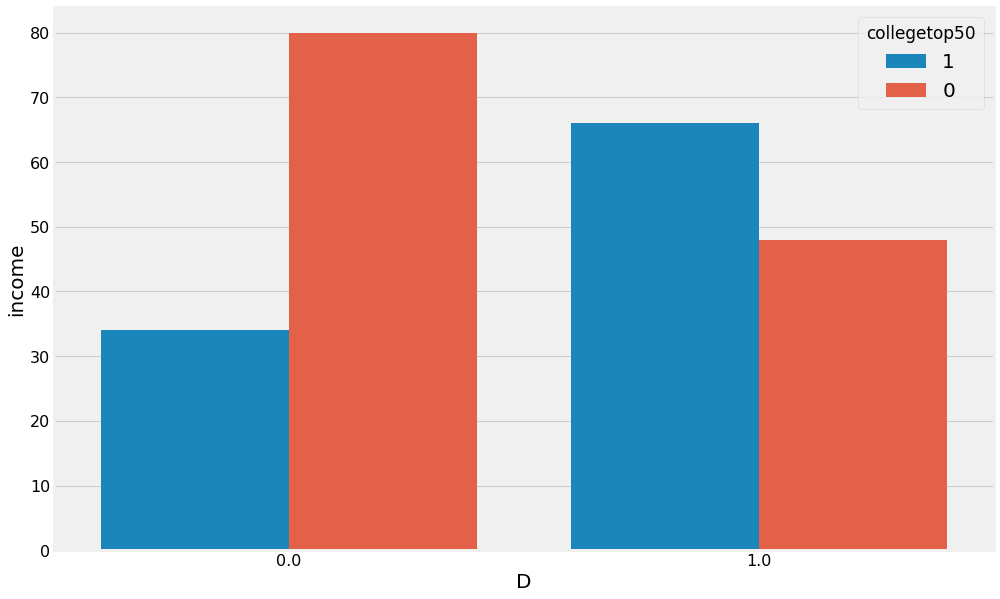

In [10]:
subset = data.groupby(by=['D', 'collegetop50']).count().reset_index()
sns.barplot(x=subset['D'], y=subset['income'], hue=subset['collegetop50'], hue_order=[1,0]);

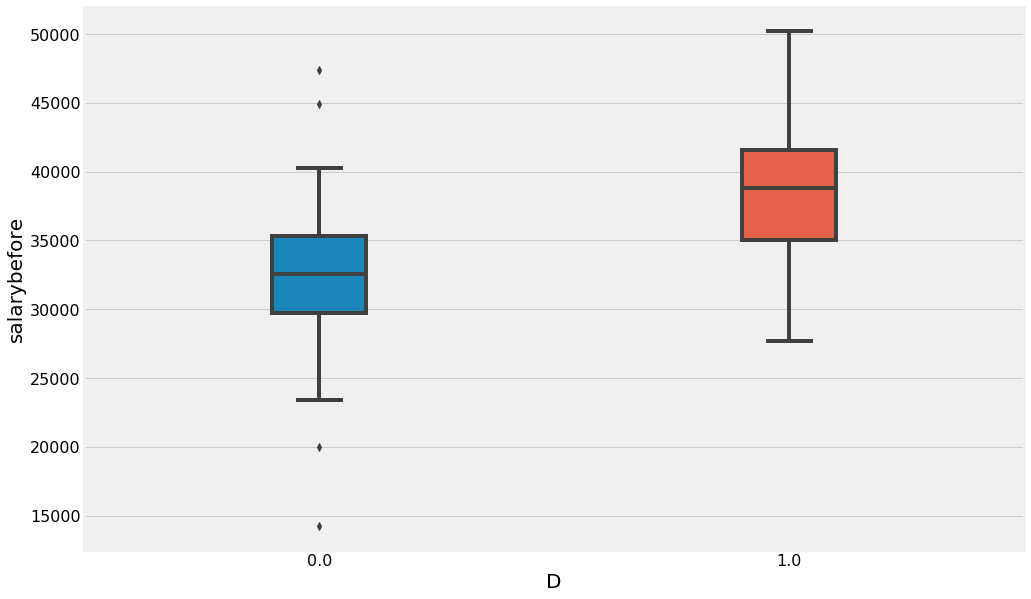

In [11]:
sns.boxplot(x=data['D'], y=data['salarybefore'], width=0.2);

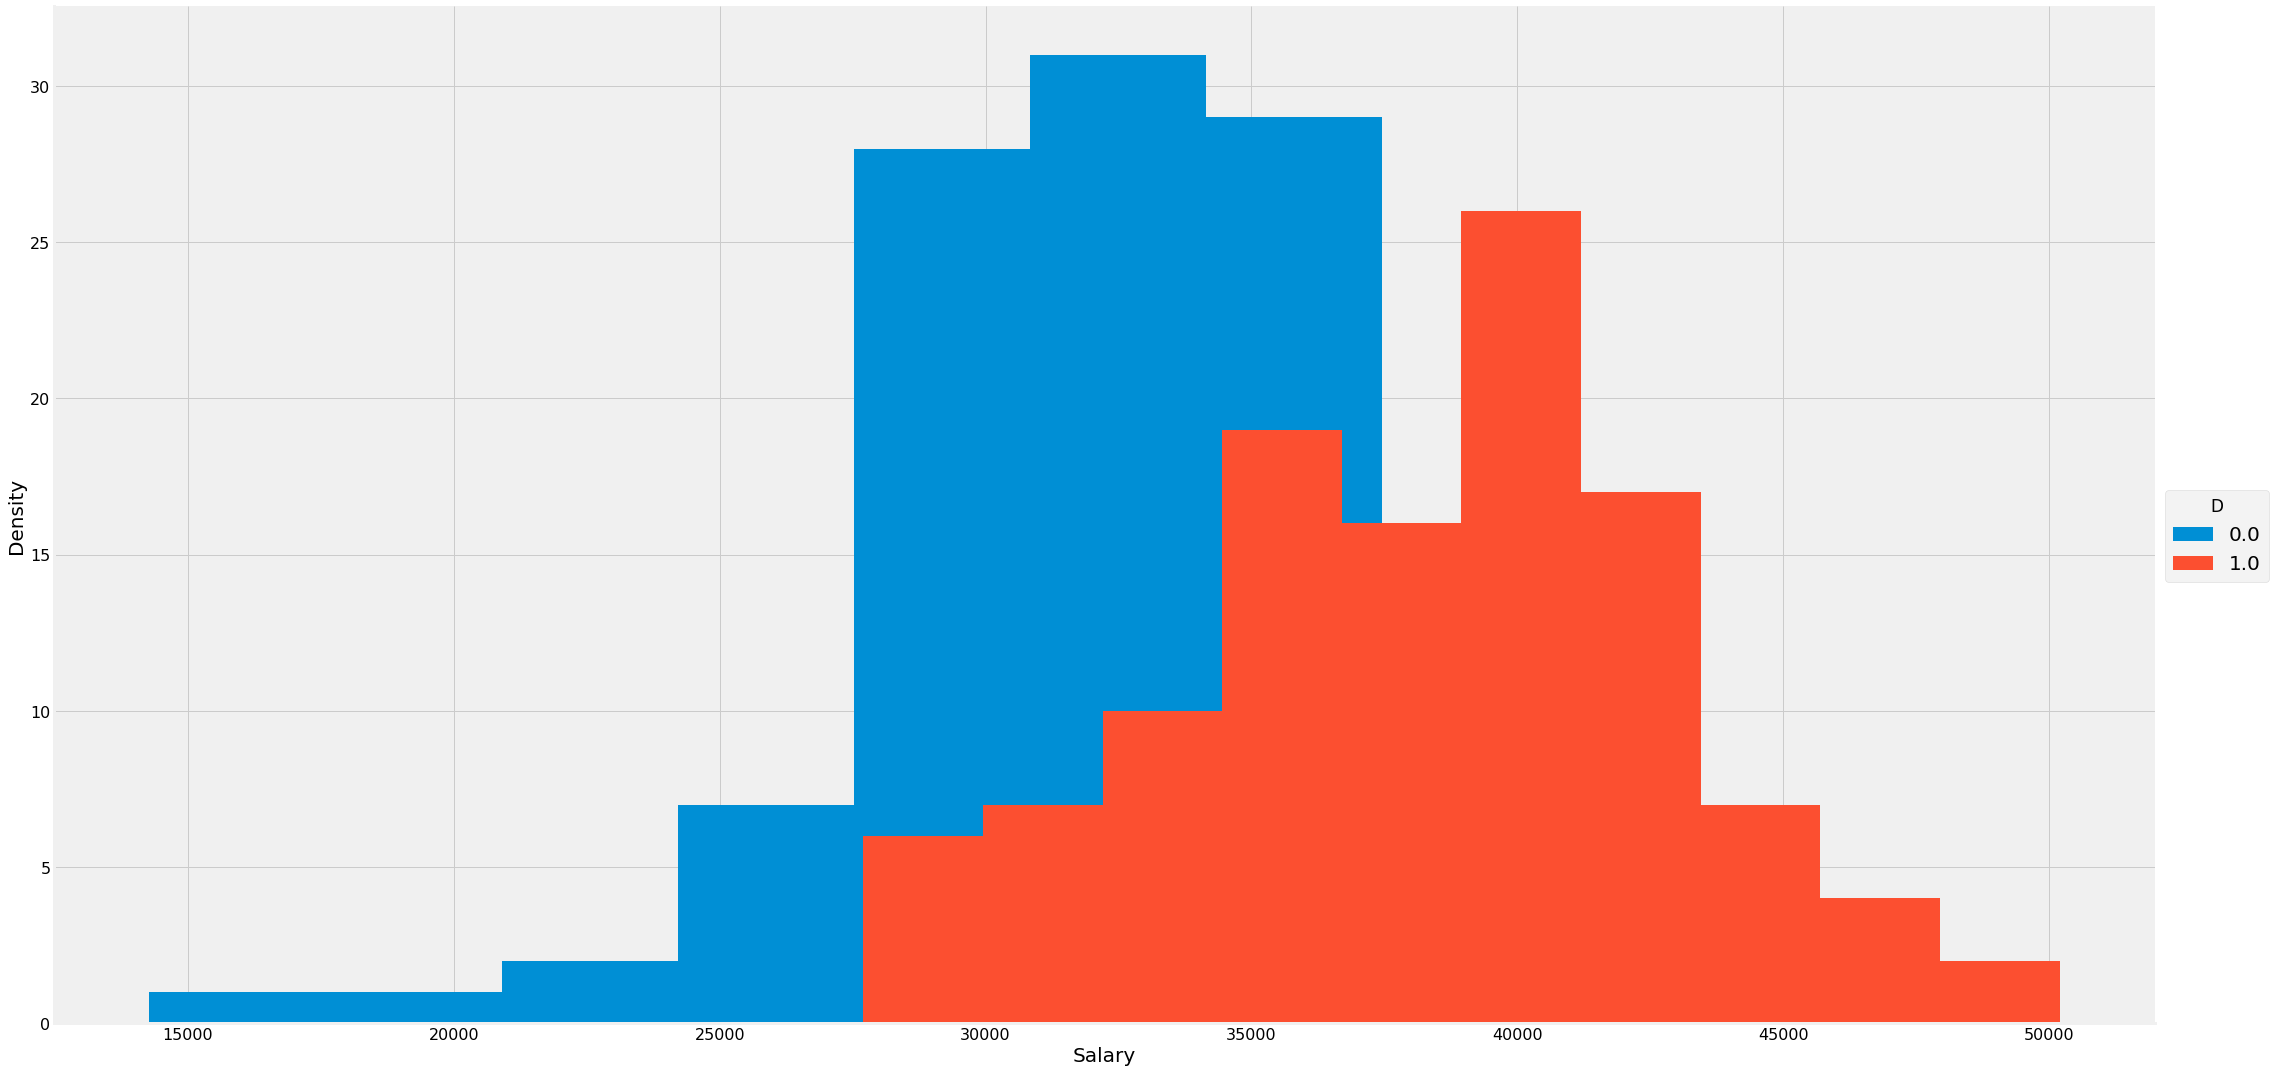

In [12]:
g = sns.FacetGrid(data, hue="D", size=15, aspect=2)
g = g.map(plt.hist, "salarybefore").add_legend()
plt.ylabel("Density")
plt.xlabel("Salary")

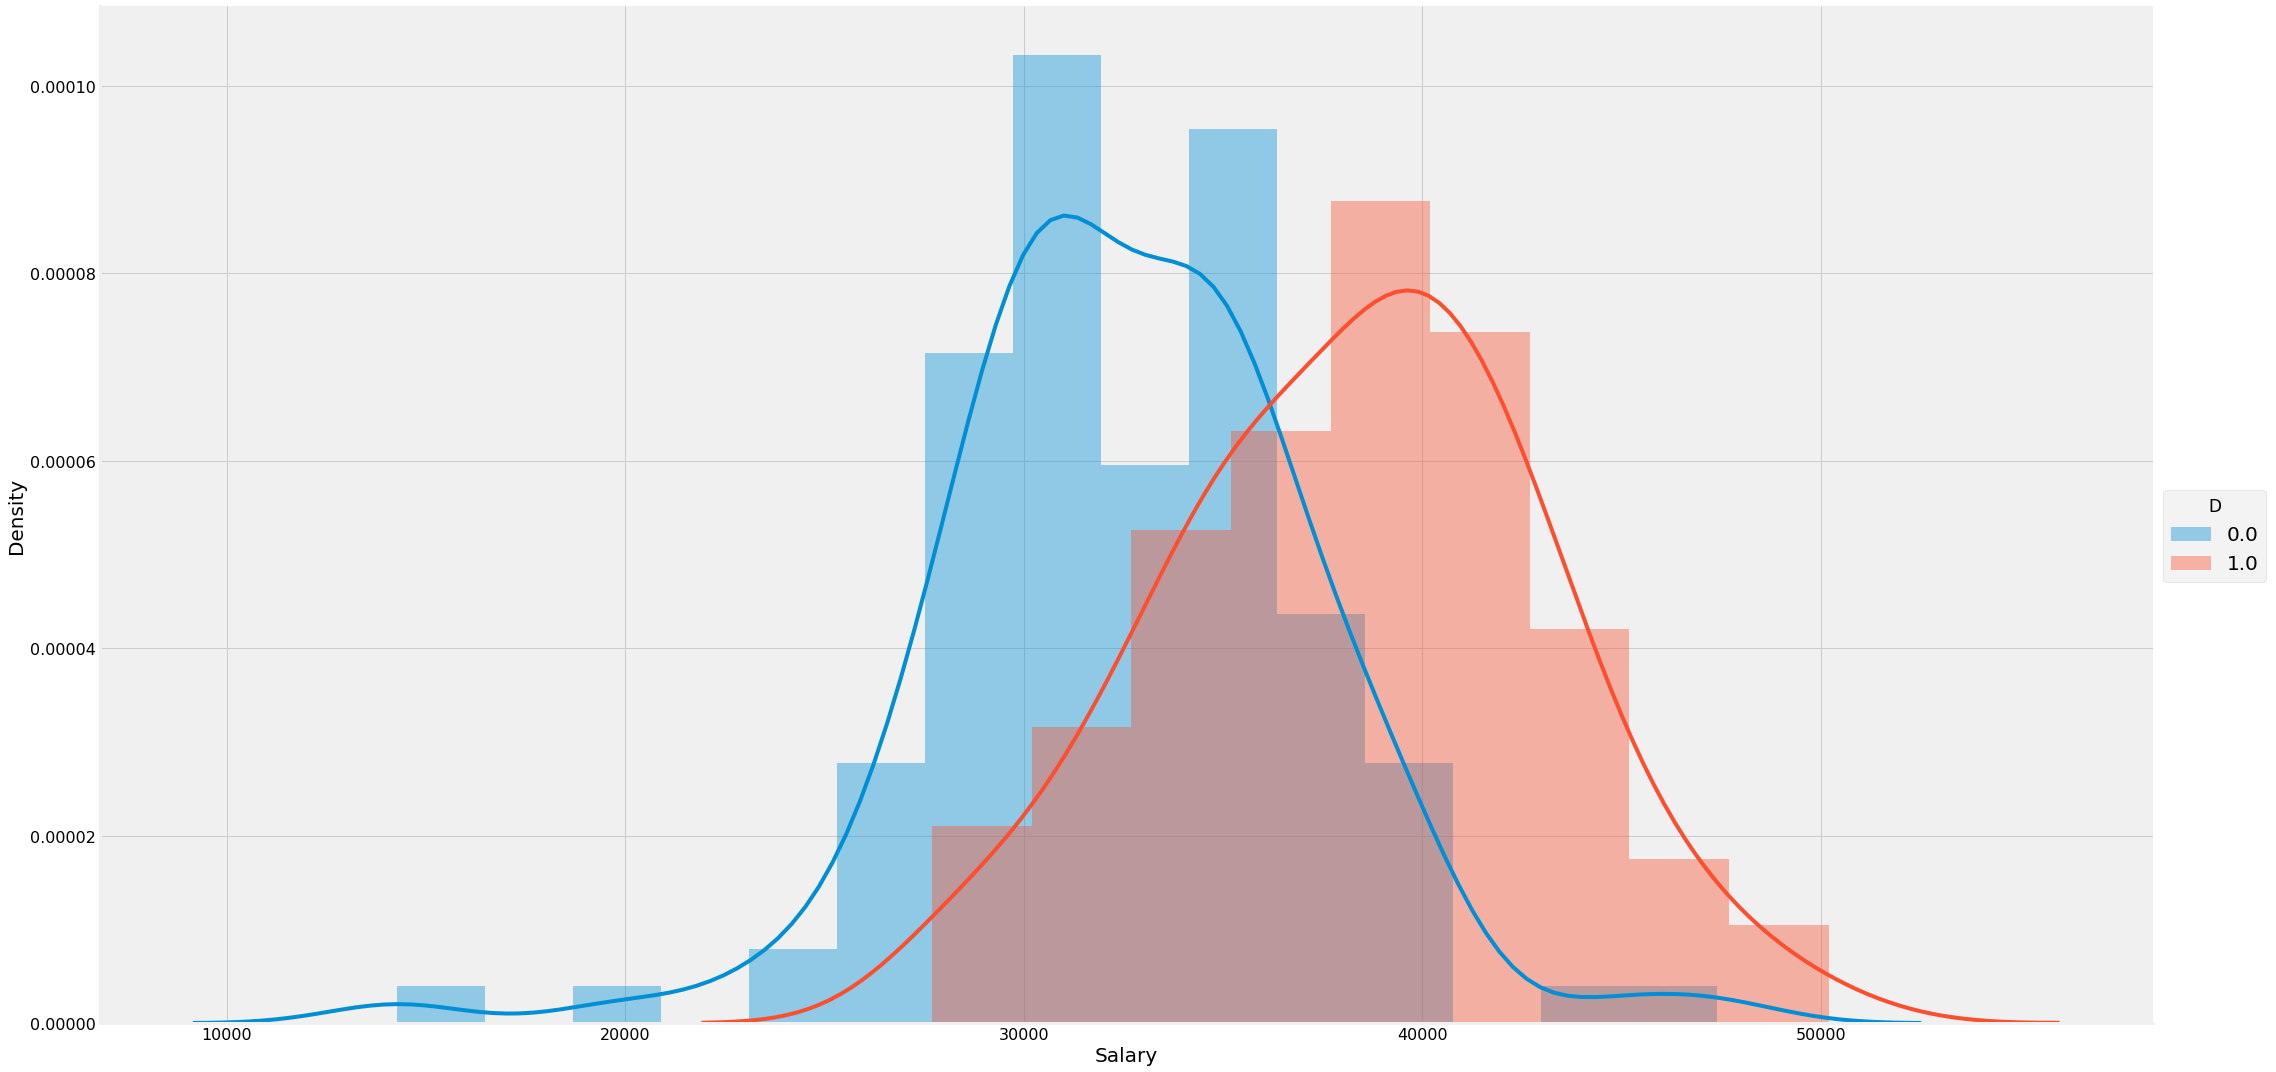

In [13]:
g = sns.FacetGrid(data, hue="D", size=15, aspect=2)
g = g.map(sns.distplot, "salarybefore").add_legend()
plt.ylabel("Density")
plt.xlabel("Salary")

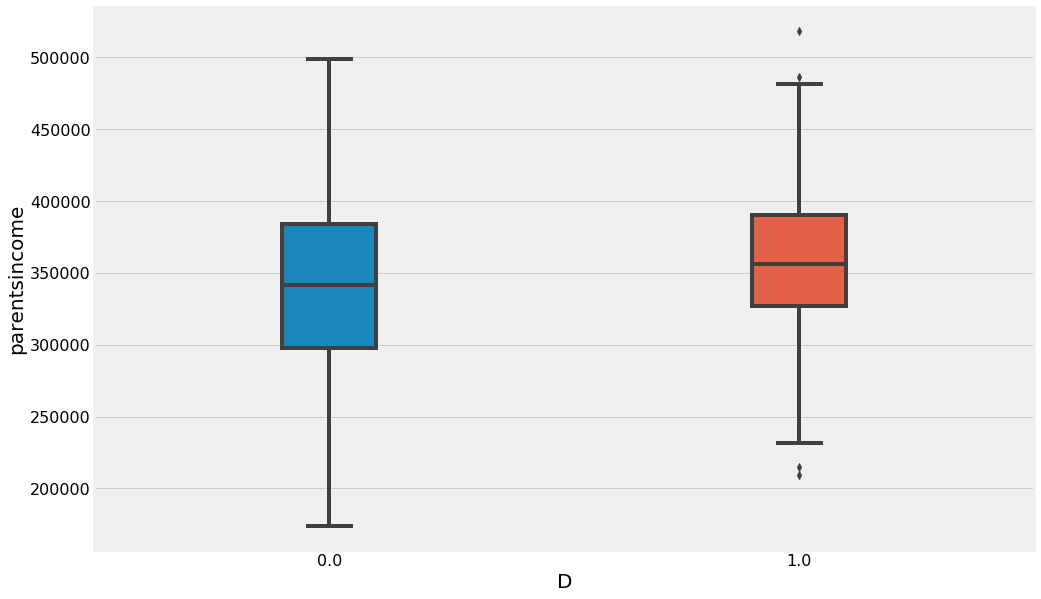

In [14]:
sns.boxplot(x=data['D'], y=data['parentsincome'], width=0.2);

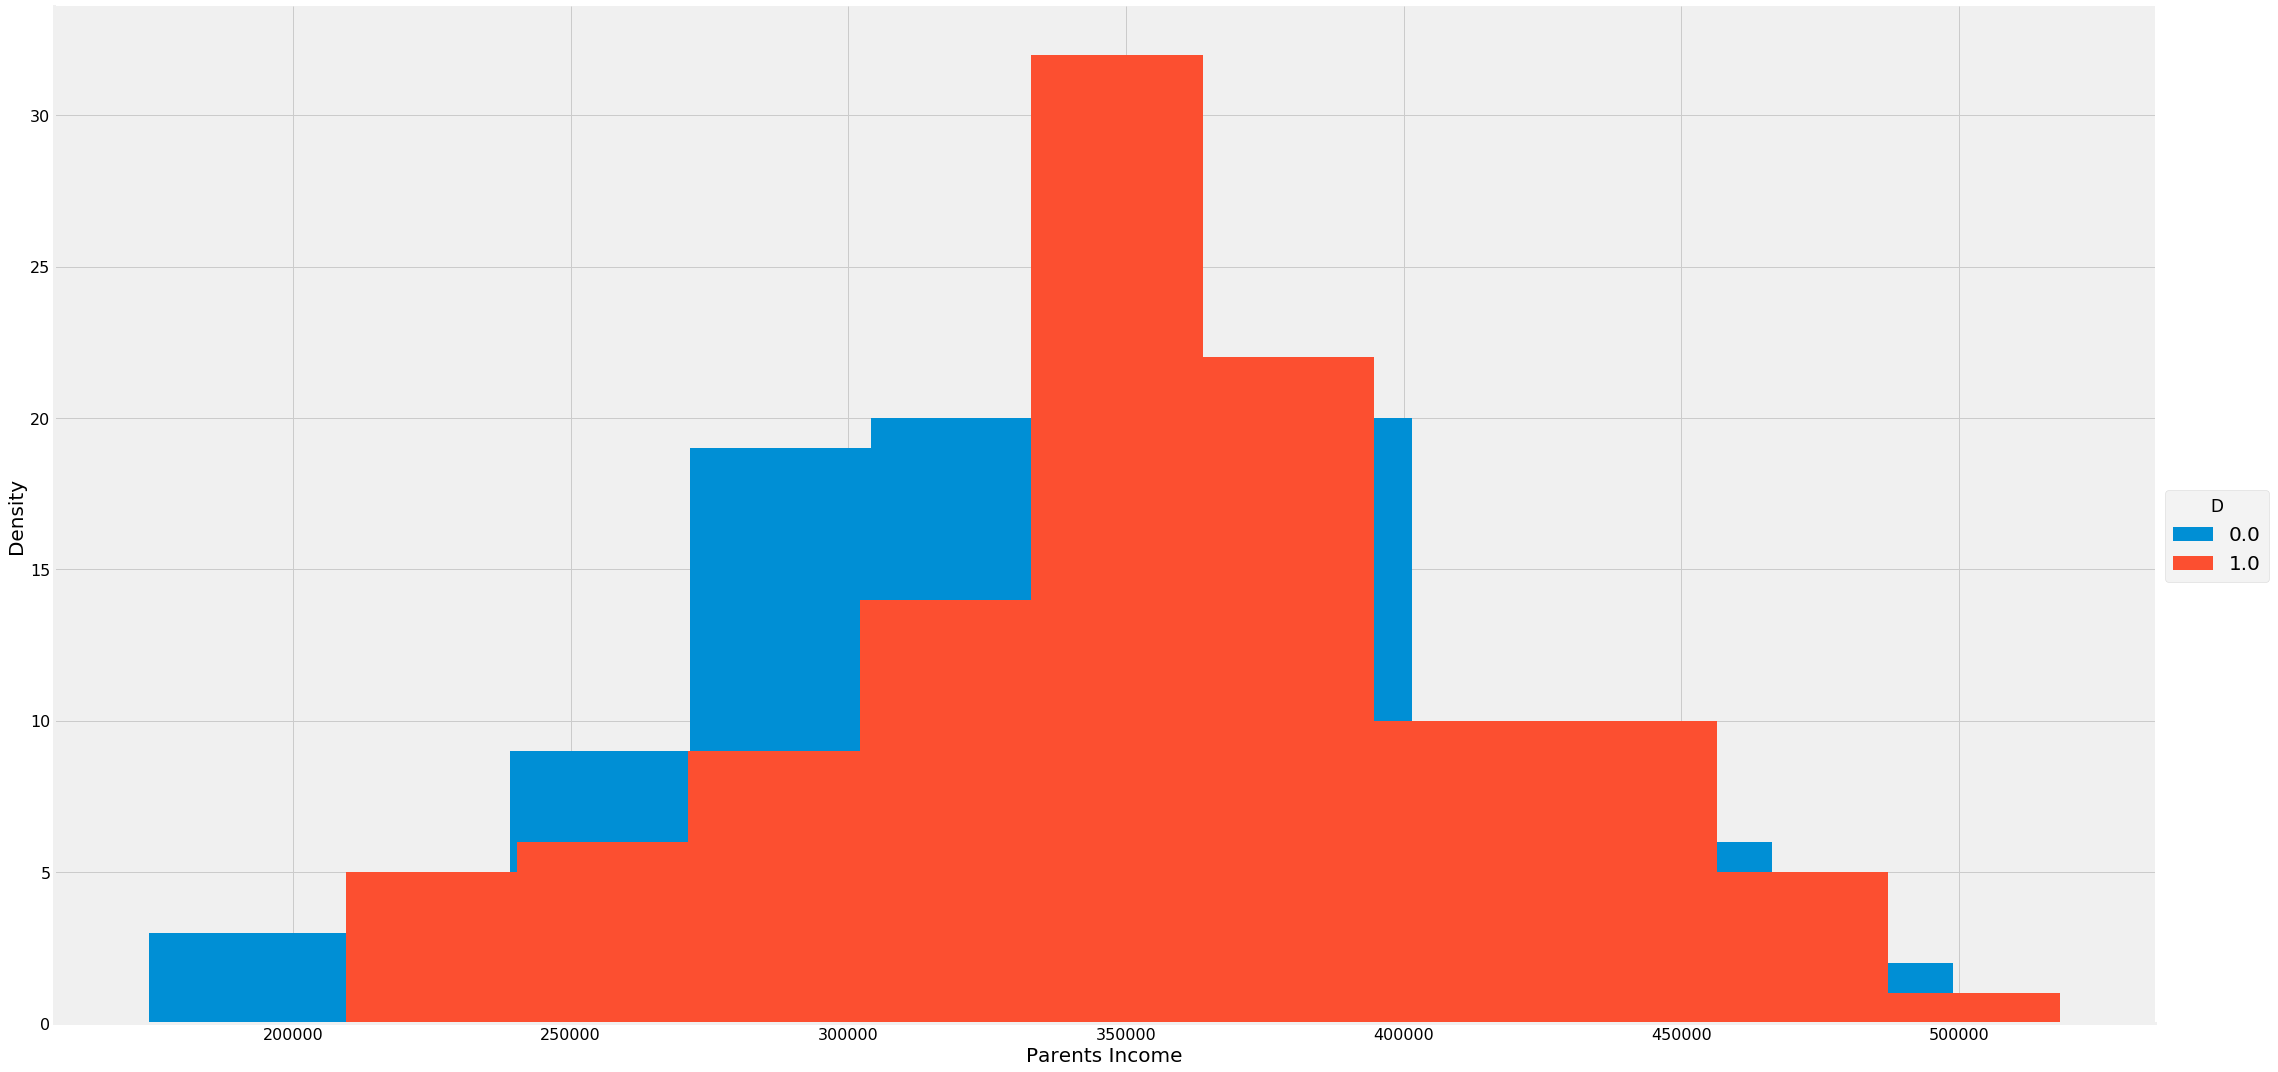

In [15]:
g = sns.FacetGrid(data, hue="D", size=15, aspect=2)
g = g.map(plt.hist, "parentsincome").add_legend()
plt.ylabel("Density")
plt.xlabel("Parents Income")

(0, 9e-06)

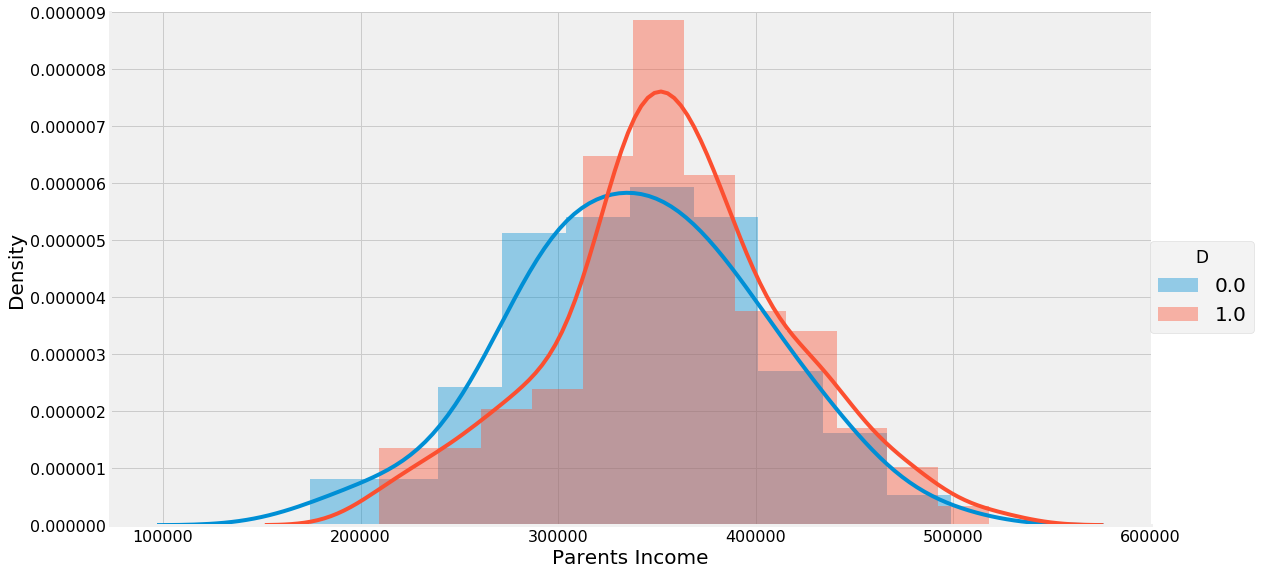

In [16]:
g = sns.FacetGrid(data, hue="D", size=8, aspect=2)
g = g.map(sns.distplot, "parentsincome").add_legend()
plt.ylabel("Density")
plt.xlabel("Parents Income")
plt.ylim((0,0.000009))

In [17]:
# Regress collegegpa on D
X = sm.add_constant(data['D'].values)
y = data['collegegpa'].values

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     51.65
Date:                Sat, 20 Jan 2018   Prob (F-statistic):           9.55e-12
Time:                        17:54:09   Log-Likelihood:                 248.16
No. Observations:                 228   AIC:                            -492.3
Df Residuals:                     226   BIC:                            -485.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7087      0.008    483.832      0.0

In [18]:
# Regress collegetop50 on D
X = sm.add_constant(data['D'].values)
y = data['collegetop50'].values

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     19.65
Date:                Sat, 20 Jan 2018   Prob (F-statistic):           1.45e-05
Time:                        17:54:09   Log-Likelihood:                -154.24
No. Observations:                 228   AIC:                             312.5
Df Residuals:                     226   BIC:                             319.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2982      0.045      6.661      0.0

In [19]:
# Regress salarybefore on D
X = sm.add_constant(data['D'].values)
y = data['salarybefore'].values

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     86.14
Date:                Sat, 20 Jan 2018   Prob (F-statistic):           1.42e-17
Time:                        17:54:09   Log-Likelihood:                -2248.2
No. Observations:                 228   AIC:                             4500.
Df Residuals:                     226   BIC:                             4507.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.261e+04    436.119     74.769      0.0

In [20]:
# Regress parentsincome on D
X = sm.add_constant(data['D'].values)
y = data['parentsincome'].values

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     4.300
Date:                Sat, 20 Jan 2018   Prob (F-statistic):             0.0392
Time:                        17:54:09   Log-Likelihood:                -2835.9
No. Observations:                 228   AIC:                             5676.
Df Residuals:                     226   BIC:                             5683.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.399e+05   5742.538     59.195      0.0

In [21]:
# Regress income on D, collegegpa, collegetop50, salarybefore, parentsincome
X = sm.add_constant(data[['D', 'collegegpa', 'collegetop50', 'salarybefore',
       'parentsincome']].values)
y = data['income'].values

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.354e+05
Date:                Sat, 20 Jan 2018   Prob (F-statistic):               0.00
Time:                        17:54:09   Log-Likelihood:                -2105.8
No. Observations:                 228   AIC:                             4224.
Df Residuals:                     222   BIC:                             4244.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         8.2e+04   7693.178     10.659      0.0

In [22]:
naive_estimate

88033.0

In [23]:
treatment_coeff = results.params[1]
treatment_coeff

27829.260348788928

In [24]:
naive_estimate - treatment_coeff

60203.739651211072

Now, if we assume that all the observable featurs we have fully capture the selection problem, then we get a coefficient on the treatment ($D$) of \$27,829. That is to say, the effect of going to harris, while controlling for all other variables, results in an average increase of \$27,829 in income.

Our naive calculation implied that the average increase was: $88,033

Thus, our naive calculation was overestimating by: $60,203

The takeaway here is that when we have a selection problem, out naive estimate will be biased!

### The naive estimator with no selection problem!

In [25]:
data = pd.read_stata("Dataset_Balanced.dta")
data.head()

income    D  collegegpa  collegetop50  salarybefore  parentsincome
0  1599937.000  0.0    3.839839           0.0  30734.337891  341021.812500
1  1398235.375  0.0    3.879152           0.0  41814.113281  335796.343750
2  1343252.250  0.0    3.833164           0.0  42751.250000  401885.718750
3  1384309.125  0.0    3.552280           0.0  38449.406250  221363.250000
4  1392014.000  0.0    3.769191           1.0  39447.023438  248182.046875

Box plots look pretty identical! - Doesnt seem to be a selection problem!

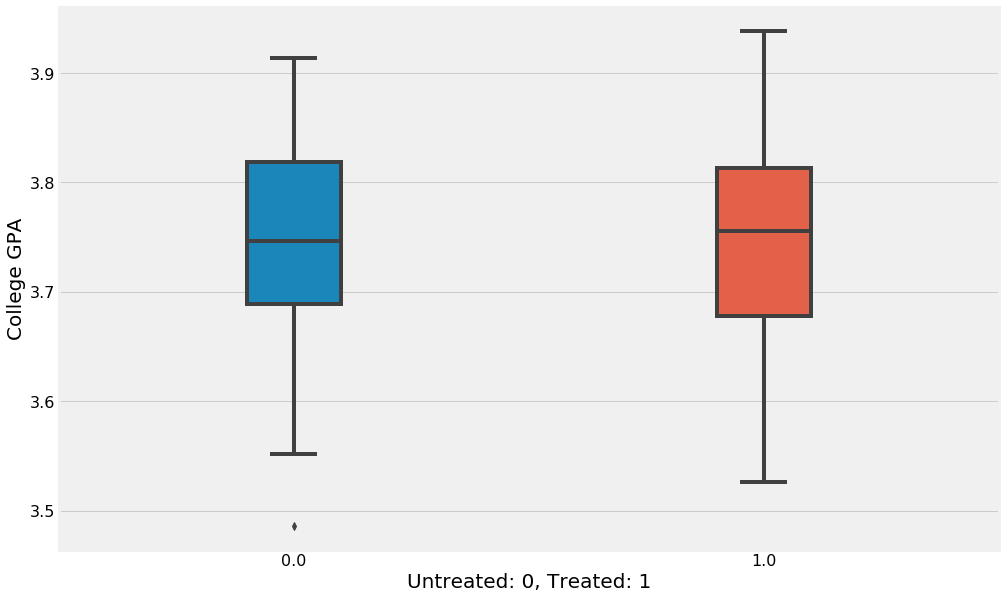

In [26]:
gen_boxplot(data, "collegegpa", "D", "Untreated: 0, Treated: 1", "College GPA", width=0.2)

Same with the barplots!

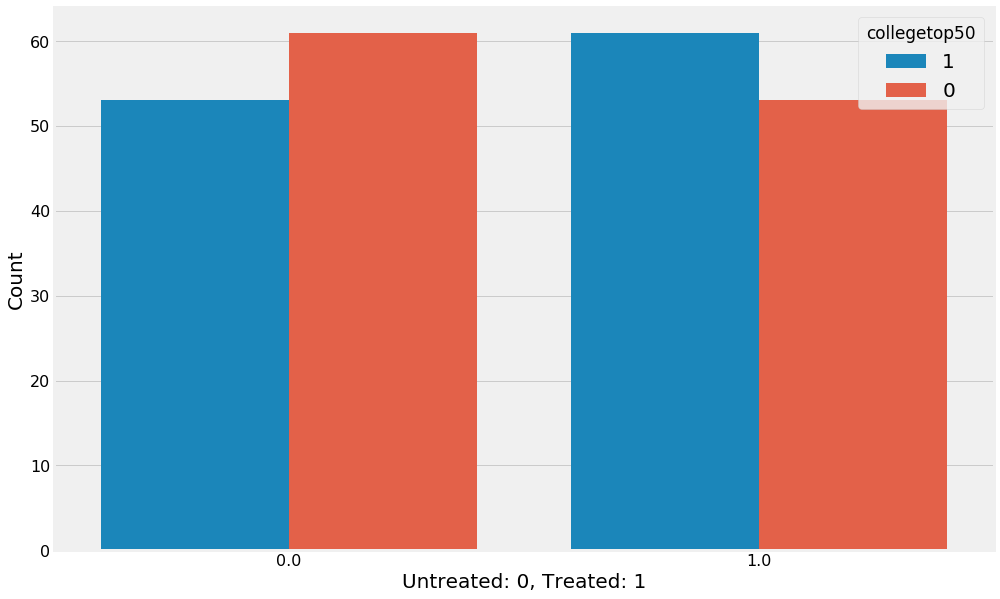

In [27]:
gen_grouped_bar(data, ['D', 'collegetop50'], x='D', y='income', hue='collegetop50', hue_order=[1,0], xlabel="Untreated: 0, Treated: 1")

Looking pretty good here too!

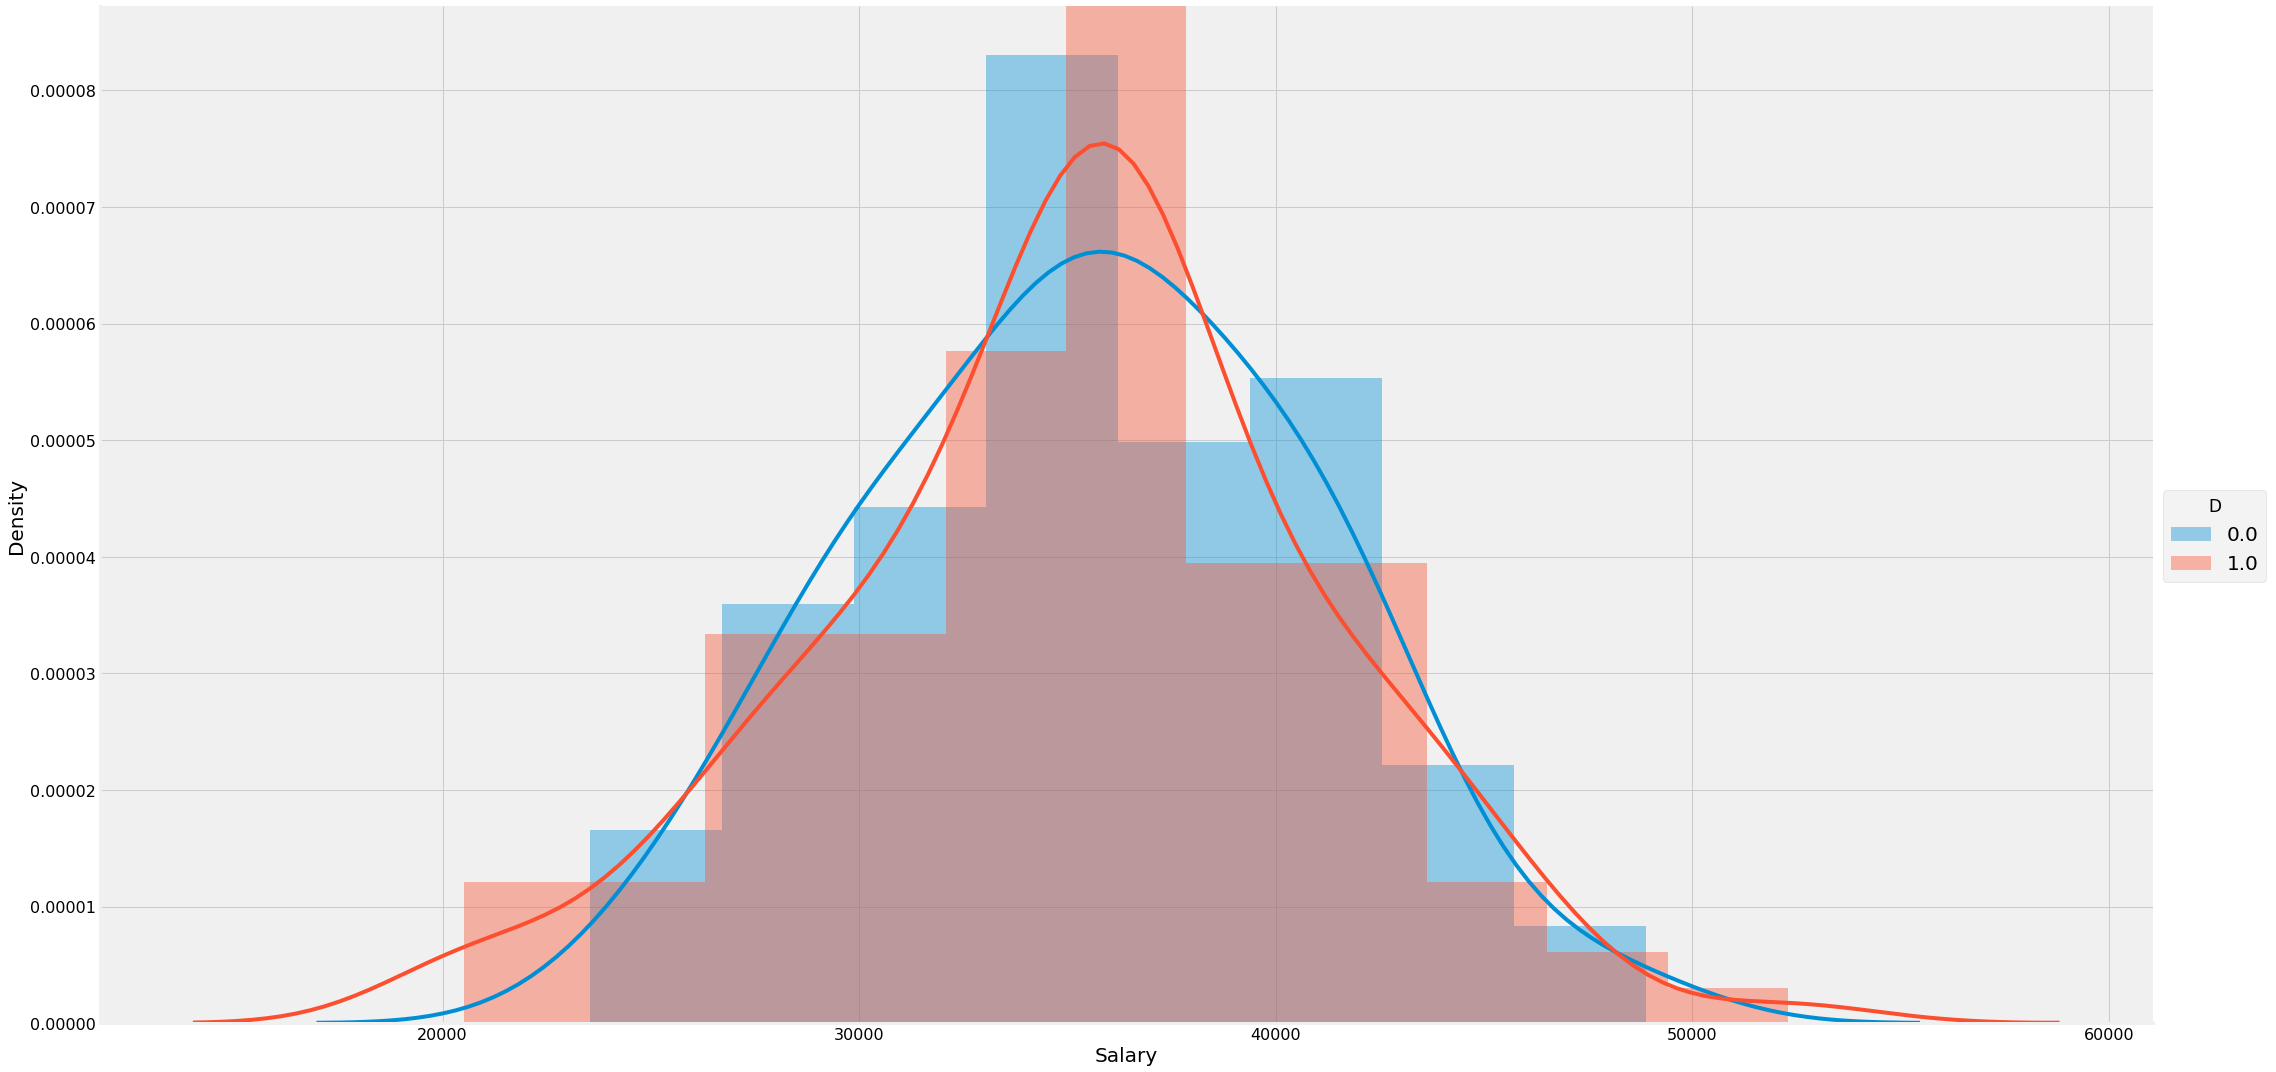

In [28]:
gen_overlapped_dist(data,"salarybefore", 'D', 15, 2, "Salary", "Density")

In [29]:
data.head()

income    D  collegegpa  collegetop50  salarybefore  parentsincome
0  1599937.000  0.0    3.839839           0.0  30734.337891  341021.812500
1  1398235.375  0.0    3.879152           0.0  41814.113281  335796.343750
2  1343252.250  0.0    3.833164           0.0  42751.250000  401885.718750
3  1384309.125  0.0    3.552280           0.0  38449.406250  221363.250000
4  1392014.000  0.0    3.769191           1.0  39447.023438  248182.046875

In [30]:
regress(data=data, feature_lst=['D'], target='collegegpa')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                   0.02359
Date:                Sat, 20 Jan 2018   Prob (F-statistic):              0.878
Time:                        17:54:10   Log-Likelihood:                 221.84
No. Observations:                 228   AIC:                            -439.7
Df Residuals:                     226   BIC:                            -432.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7442      0.009    435.216      0.0

In [31]:
regress(data=data, feature_lst=['D'], target='collegetop50')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.118
Date:                Sat, 20 Jan 2018   Prob (F-statistic):              0.291
Time:                        17:54:10   Log-Likelihood:                -164.92
No. Observations:                 228   AIC:                             333.8
Df Residuals:                     226   BIC:                             340.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4649      0.047      9.909      0.0

In [32]:
regress(data=data, feature_lst=['D'], target='salarybefore')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.2429
Date:                Sat, 20 Jan 2018   Prob (F-statistic):              0.623
Time:                        17:54:10   Log-Likelihood:                -2291.1
No. Observations:                 228   AIC:                             4586.
Df Residuals:                     226   BIC:                             4593.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.555e+04    526.498     67.529      0.0

In [33]:
regress(data=data, feature_lst=['D'], target='parentsincome')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7919
Date:                Sat, 20 Jan 2018   Prob (F-statistic):              0.374
Time:                        17:54:10   Log-Likelihood:                -2843.9
No. Observations:                 228   AIC:                             5692.
Df Residuals:                     226   BIC:                             5699.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        3.43e+05   5946.688     57.672      0.0

We see no statistical significance in any of the above! Thus no significant differences on these features between the two groups!

Let's now recalculate the naive estimator!

In [34]:
treated_avg_mean = data[data['D'] == 1.0]['income'].mean()
treated_avg_mean
untreated_avg_mean = data[data['D'] == 0.0]['income'].mean()
untreated_avg_mean
naive_estimate = treated_avg_mean - untreated_avg_mean
naive_estimate

88032.875

Woah - we have exactly the same difference - hmm, let's now control for all our features and see what happens!

In [35]:
regress(data, feature_lst=list(data.columns[1:].values), target="income")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     2.048
Date:                Sat, 20 Jan 2018   Prob (F-statistic):             0.0731
Time:                        17:54:10   Log-Likelihood:                -3118.7
No. Observations:                 228   AIC:                             6249.
Df Residuals:                     222   BIC:                             6270.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.262e+06   5.85e+05      2.159      0.0

From the above, we see that the coeff for $D$ is 88530.0

In [36]:
naive_estimate - 8.853e04

-497.125

we see that now our naive estimate slightly under estimated - but this is very very close to our naive estimate. it is safe to say that in this instance, there is no selection problem!

Furthermore notice that the F stat is NOT significant at the 5% level!

Let's change our regression a little to see if our adj $R^2$ changes.

In [37]:
regress(data, ['D'], target='income')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     9.808
Date:                Sat, 20 Jan 2018   Prob (F-statistic):            0.00197
Time:                        17:54:10   Log-Likelihood:                -3119.0
No. Observations:                 228   AIC:                             6242.
Df Residuals:                     226   BIC:                             6249.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.289e+06   1.99e+04     64.846      0.0

Yup - our adj R^2 increased! As such, its better to leave out all the covariates all together!

### Conclusion

- naive estimator is unbiased when there are no selection problems.


- Empircally, there will **always** be selection problems.


- When faced with selection problems, controlling for covariates helps give a better estimate of the actual treatment effect. However, this is not an easy task!

#### What could go wrong?

- Might make the wrong selection of covariates! We might never find **the** covariate that explains the relationship.

- collecting data on certain observable covariates might be costly or unethical!


- plenty of unobserved covariates that may explain our Y - but we will never really know. Furthermore, lets say you did highlight an unobservable Y that could play a significant role - you still wouldnt be able to measure it!

Program evaluation is about solving this selection problem amongst observable and unobservable covariates.

Many ways to help observe the counter factual of $E(Y_{0i})$ :

- RCTs

- diff-in-diff

- instrumental variables

- regression discontinuity

- matching

By using statisical models, we hope to estimate the counterfactuals - that is, tbe hypothetical situation we would never be able to 'see'.

In essence, we are trying to estimate what we would have observed, if the treated had **not** been treated!